# Importing the required python libraries



In [1]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb # used to plot the heatmap

# from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
# from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# torch.manual_seed(0)
start1 = time.perf_counter()

In [2]:
class TabularDataset(Dataset):
    def __init__(self, data, cat_cols=None, output_col=None):
        """
        Characterizes a Dataset for PyTorch

        Parameters
        ----------

        data: pandas data frame
        The data frame object for the input data. It must
        contain all the continuous, categorical and the
        output columns to be used.

        cat_cols: List of strings
        The names of the categorical columns in the data.
        These columns will be passed through the embedding
        layers in the model. These columns must be
        label encoded beforehand. 

        output_col: string
        The name of the output variable column in the data
        provided.
        """

        self.n = data.shape[0] # n stores the total number of data points

        if output_col:
            self.y = data[output_col].astype(np.float32).values.reshape(-1, 1) #data[output_col] contains two columns 
                                                                            #(first column is the index). This line converts it 
                                                                            # to single column
            
        else:
            self.y = np.zeros((self.n, 1)) # a general case when out

        self.cat_cols = cat_cols if cat_cols else [] # categorical inputs are stored in "self.cat_cols"
        self.cont_cols = [
            col for col in data.columns if col not in self.cat_cols + [output_col] # finds out the columns that have 
                                                                                   # contionuos inputs
        ]

        if self.cont_cols:
            self.cont_X = data[self.cont_cols].astype(np.float32).values # The data corresponding to 
                                                                         # continuous columns are stored in "self.cont_x"
        else:
            self.cont_X = np.zeros((self.n, 1))

        if self.cat_cols:
            self.cat_X = data[cat_cols].astype(np.int64).values # The data corresponding to 
                                                                # categorical columns are stored in "self.cont_x"
        else:
            self.cat_X = np.zeros((self.n, 1))

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data as a triplet --> #(output, continous inputs, categorical inputs)
        """
        return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

# Definition of the Neural network

In [3]:
class FeedForwardNN(nn.Module):
    def __init__(
        self,
        emb_dims,
        no_of_cont,
        lin_layer_sizes,
        output_size,
        emb_dropout,
        lin_layer_dropouts,
    ):

        """
        Parameters
        ----------

        emb_dims: List of two element tuples
        This list will contain a two element tuple for each
        categorical feature. The first element of a tuple will
        denote the number of unique values of the categorical
        feature. The second element will denote the embedding
        dimension to be used for that feature.

        no_of_cont: Integer
        The number of continuous features in the data.

        lin_layer_sizes: List of integers.
        The size of each linear layer. The length will be equal
        to the total number
        of linear layers in the network.

        output_size: Integer
        The size of the final output.

        emb_dropout: Float
        The dropout to be used after the embedding layers.

        lin_layer_dropouts: List of floats
        The dropouts to be used after each linear layer.
        """

        super().__init__()

        # Embedding layers of categorical inputs
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])

        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.no_of_cont = no_of_cont

        # Linear Layers of the nueral network
        first_lin_layer = nn.Linear(
            self.no_of_embs + self.no_of_cont, lin_layer_sizes[0]
        ) # first layer where data is fed into the network
        # Following lines define the hidden layers
        self.lin_layers = nn.ModuleList(
            [first_lin_layer]
            + [
                nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
                for i in range(len(lin_layer_sizes) - 1)
            ]
        )
        # Initializing the weights of neural network layers
        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        # Output Layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1], output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm Layers, It is used to normalize the data into the layers to avoid overfitting and to optimize network
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
        self.bn_layers = nn.ModuleList(
            [nn.BatchNorm1d(size) for size in lin_layer_sizes]
        )

        # Dropout Layers used as regularization
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.droput_layers = nn.ModuleList(
            [nn.Dropout(size) for size in lin_layer_dropouts]
        )

    def forward(self, cont_data, cat_data):
        # This function defines the mathematical operations of the neural network 
        if self.no_of_embs != 0: # Defines the embedding layer of categorical inputs
            x = [
                emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)
            ]
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x) # dropout regularization of categorical inputs 

        if self.no_of_cont != 0:
            normalized_cont_data = self.first_bn_layer(cont_data) # defines the linear (normal nueral net hidden layer)
                                                                  # for continous inputs

            if self.no_of_embs != 0:
                x = torch.cat([x, normalized_cont_data], 1)
            else:
                x = normalized_cont_data
        # Batch normalization operation is done in this for loop
        for lin_layer, dropout_layer, bn_layer in zip( 
            self.lin_layers, self.droput_layers, self.bn_layers
        ):

            x = F.relu(lin_layer(x))
#             x = F.sigmoid(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)

        x = self.output_layer(x)

        return x # Returns the output of the network

In [4]:
cat_dims = [2]* 57
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [5]:
device = torch.device('cpu')
model = FeedForwardNN(emb_dims, no_of_cont=3, lin_layer_sizes=[256,256,256], output_size=1, emb_dropout=0.2, lin_layer_dropouts=[0.2, 0.2, 0.2]).to(device)
      
model.load_state_dict(torch.load('NN_model.pt', map_location=device))

<All keys matched successfully>

# Data loading and preprocessing

In [6]:
# The data is read as a pandas data frame
data = pd.read_csv("finalized_data.csv").dropna()

# Data point to be predicted

In [7]:
_input = [12.0,
1,
2,
1,
2,
9.0,
1,
0.0,
10.0,
[-60.6, -45.0, 3.6],
[-60.6, -45.0, 2.8],
[-60.6, -45.0, 2.0],
[-60.6, -45.0, 1.2],
[-60.6, -45.0, 0.4],
[-59.8, -45.0, 3.6],
[-59.8, -45.0, 2.8],
[-59.8, -45.0, 2.0],
[-59.8, -45.0, 1.2],
[-59.8, -45.0, 0.4],
[-59.0, -45.0, 3.6],
[-59.0, -45.0, 2.8],
[-59.0, -45.0, 2.0],
[-59.0, -45.0, 1.2],
[-59.0, -45.0, 0.4],
[-58.2, -45.0, 3.6],
[-58.2, -45.0, 2.8],
[-58.2, -45.0, 2.0],
[-58.2, -45.0, 1.2],
[-58.2, -45.0, 0.4],
[-57.4, -45.0, 3.6],
[-57.4, -45.0, 2.8],
[-57.4, -45.0, 2.0],
[-57.4, -45.0, 1.2],
[-57.4, -45.0, 0.4],
         
]

In [8]:
def data_create(_inp):
    test_dat=np.zeros((25,13))
    tmp = np.tile(_inp[0],(25)) 
    test_dat[:,0] = tmp
    tmp = np.tile(_inp[1],(25))
    test_dat[:,1] = tmp
    tmp = np.tile(_inp[2],(25))
    test_dat[:,2] = tmp
    tmp = np.tile(_inp[3],(25))
    test_dat[:,3] = tmp
    tmp = np.tile(_inp[4],(25))
    test_dat[:,4] = tmp
    tmp = np.tile(_inp[5],(25))
    test_dat[:,5] = tmp
    tmp = np.tile(_inp[6],(25))
    test_dat[:,6] = tmp
    tmp = np.tile(_inp[7],(25))
    test_dat[:,7] = tmp
    tmp = np.tile(_inp[8],(25))
    test_dat[:,8] = tmp

    for i in range(9,34):
        tmp =list(_input[i])  
        tmp = np.asarray(tmp)
        tmp = np.reshape(tmp,(1,tmp.shape[0]))
        test_dat[i-9,9:12] = tmp
    return test_dat


In [9]:
n = len(_input)/34
test_data=np.zeros((0,13))
start=0
for i in range(int(n)):
    T = data_create(_input[start:start+34])
    test_data = np.concatenate((test_data,T),axis=0)
    start = start+34

 
test_data = pd.DataFrame(test_data, columns=[str(i) for i in range(13)])  

dat = test_data.values
new_dat = np.zeros((test_data.shape[0], test_data.shape[1]))

In [10]:
for i in range(int(n)):
    cur = dat[i*25,:] 
    D = data[data['0'] == int(cur[0])]
    if D.shape[0]!=0:
     
        D = D[D['1'] == cur[1]] 
        
        D = D[D['2'] == cur[2]] 
        
        D = D[D['3'] == cur[3]] 
        
        D = D[D['4'] == cur[4]] 
        
        D = D[D['5'] == cur[5]] 
        
        D = D[D['6'] == cur[6]] 
        
        D = D[D['7'] == cur[7]] 

        D = D[D['8'] == cur[8]] 
        
    
    D = D.values
 
    test_data.iloc[i*25:(i+1)*25,9:12] = D[:,9:12]

In [11]:
# Array that specifies which columns are categorical inputs
categorical_features = ["0", "1", "2", "3", "4","5", "6", "7", "8"] # Except column "7", all are label encoded and "7" is 
                                                               # one-hot encoded. 
# Array that specifies which columns are continuous inputs
contnuous_features = ["9","10","11"]
output_feature = "12"  # specifies which column is output


temp={}
label_encoders = {} 
# for loop starts for label encoding
for i in range(0,len(categorical_features)): 
    #codes for one-hot encoding
    label_encoders[categorical_features[i]] = OneHotEncoder(handle_unknown='ignore')
    label_encoders[categorical_features[i]].fit(data[categorical_features[i]].values.reshape(-1,1))
    temp[categorical_features[i]]=label_encoders[categorical_features[i]].transform(test_data[categorical_features[i]].values.reshape(-1,1)).toarray() 


In [12]:
ind=13
new_categorical_features=[]
for i in range(0,len(categorical_features)):
    for j in range(0,temp[categorical_features[i]].shape[1]):
        test_data[str(ind)] = temp[categorical_features[i]][:,j]
        new_categorical_features.append(str(ind)) # Stroing the column identity of newly added one-hot encoded columns as 
                                                  # categorical input.
        ind=ind+1
    test_data=test_data.drop([categorical_features[i]], axis=1) # The old column is deleted from the data

In [13]:
test_data.shape

(25, 61)

In [14]:
test_columns=[]
for i in range(0,test_data.shape[1]):
    test_columns.append(str(i))
    
test_data.columns = test_columns
new_categorical_features=test_columns[4:] 
output_feature=test_columns[3] 
testdataset = TabularDataset(data=test_data, cat_cols=new_categorical_features,
                             output_col=output_feature)
batchsize_test=25
testdataloader = DataLoader(testdataset, batchsize_test, shuffle=False, num_workers=0, drop_last=False)

In [15]:
predicted=np.zeros((0,1))  # Variable to store neural network prediction
for y, cont_x, cat_x in testdataloader:
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
#         y  = y.to(device)
        preds = model(cont_x, cat_x)
        preds=preds.cpu()
        predicted = np.concatenate((predicted, preds.detach().numpy()),axis=0)
        
# actual = test['5'].values # Variable storing the actual values of the testing cases
# actual=actual.reshape(actual.shape[0],1) # Reshaping for visualization 
# result=np.concatenate((actual, predicted),axis=1) # Actual value and predicted value is stored in "result" variable.
    
# print("Error MEasures:")
# MSE = mean_squared_error(actual, predicted)
# MAE = mean_absolute_error(actual, predicted)
     
# R2 = r2_score(actual, predicted)
# print(MSE)
# print(MAE)
   
# print(R2)

output_ = predicted 
y_pred = predicted

In [16]:
end = time.perf_counter()

# total time taken
print(f"Runtime of the program is {end - start1}")

Runtime of the program is 3.7559769000000003


# The output heatmap

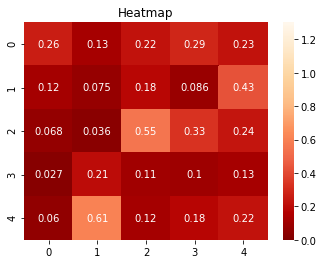

In [18]:
y_pred = np.reshape(y_pred,(5,5)) 
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Heatmap')
heat_map = sb.heatmap(y_pred,  vmin = 0, vmax = 1.30141, cmap="OrRd_r", annot=True)
plt.show()